<a href="https://colab.research.google.com/github/dhairya1606/Stock-Price-Prediction/blob/main/Stock_Price_Prediction_using_LSTM_(Long_Short_Term_Memory)_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [ ]:
def load_data(file_path):
    df = pd.read_csv(file_path, date_parser=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

In [ ]:
def preprocess_data(df):
    data = df['Close'].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    training_data_len = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:training_data_len]

    x_train, y_train = [], []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train, y_train, scaler, scaled_data, training_data_len

In [ ]:
def build_and_train_model(x_train, y_train):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    return model

In [ ]:
def predict_and_suggest_investment(model, scaler, scaled_data, training_data_len, df):
    test_data = scaled_data[training_data_len - 60:]
    x_test, y_test = [], []
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    train = df[:training_data_len]
    valid = df[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

    current_price = df['Close'].iloc[-1]
    predicted_price = predictions[-1][0]

    threshold_percentage = 1.0  # Set a threshold, e.g., 1%
    if predicted_price > current_price * (1 + threshold_percentage / 100):
        print(f"Predicted price is higher than the current price by more than {threshold_percentage}%. Consider investing.")
    else:
        print("Predicted price is not significantly higher than the current price. Do not invest.")

<ipython-input-2-b243f81740a8>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(file_path, date_parser=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8703/8703 ━━━━━━━━━━━━━━━━━━━━ 74s 8ms/step - loss: 4.8919e-05
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


<ipython-input-5-a225fdcecf9f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


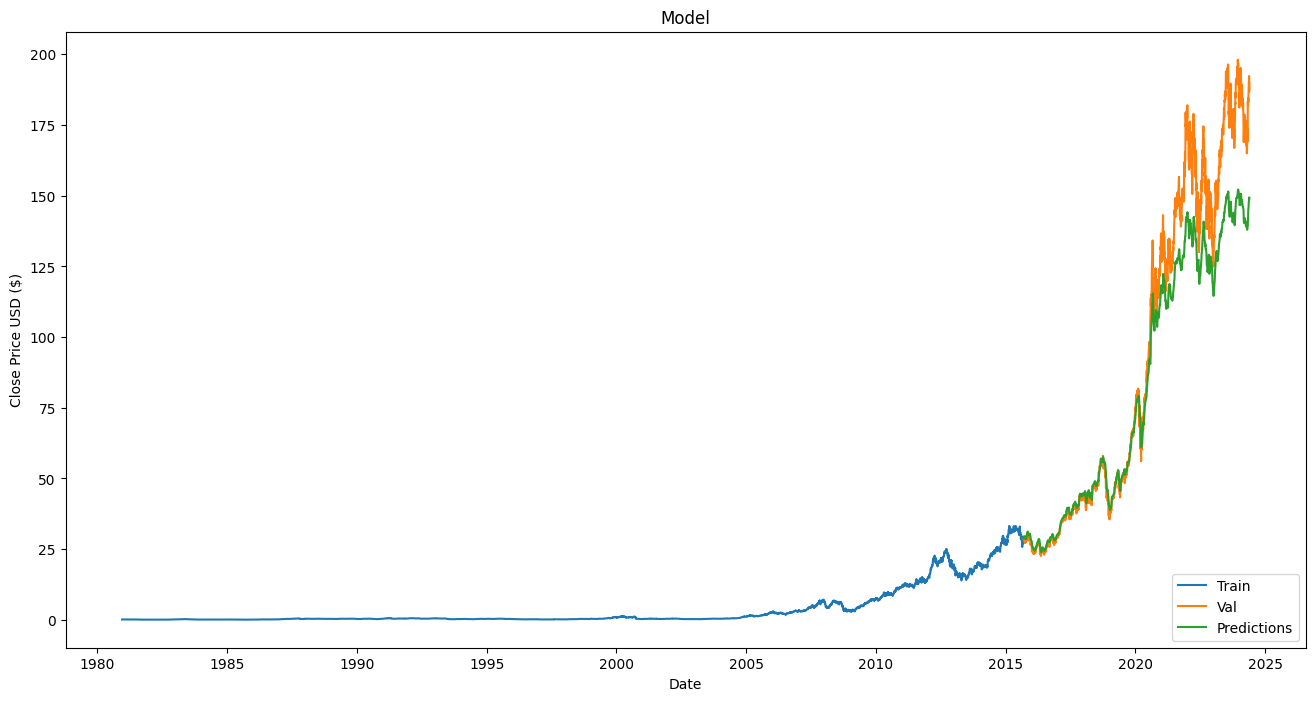

Predicted price is not significantly higher than the current price. Do not invest.


In [ ]:
if __name__ == "__main__":
    file_path = '/content/Apple Dataset.csv'  # Path to your dataset
    df = load_data(file_path)

    x_train, y_train, scaler, scaled_data, training_data_len = preprocess_data(df)

    model = build_and_train_model(x_train, y_train)

    predict_and_suggest_investment(model, scaler, scaled_data, training_data_len, df)